In [20]:
import math
from enum import Enum

import numpy as np
import torch
from einops import rearrange, repeat
from tqdm import tqdm



class GaussianRF:
    def __init__(self, n_dims, size, alpha=2, tau=3, sigma=None, device=None):

        self.n_dims = n_dims
        self.device = device

        if sigma is None:
            sigma = tau**(0.5*(2*alpha - self.n_dims))

        k_max = size//2

        if n_dims == 1:
            self.dim = [-1]
            k = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                           torch.arange(start=-k_max, end=0, step=1, device=device)), 0)

            self.sqrt_eig = size * \
                math.sqrt(2.0)*sigma * \
                ((4*(math.pi**2)*(k**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0] = 0.0

        elif n_dims == 2:
            self.dim = [-1, -2]
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size, 1)

            k_x = wavenumers.transpose(0, 1)
            k_y = wavenumers

            self.sqrt_eig = (size**2)*math.sqrt(2.0)*sigma * \
                ((4*(math.pi**2)*(k_x**2 + k_y**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0, 0] = 0.0

        elif n_dims == 3:
            self.dim = [-1, -2, -3]
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size, size, 1)

            k_x = wavenumers.transpose(1, 2)
            k_y = wavenumers
            k_z = wavenumers.transpose(0, 2)

            self.sqrt_eig = (size**3)*math.sqrt(2.0)*sigma*((4*(math.pi**2)
                                                             * (k_x**2 + k_y**2 + k_z**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0, 0, 0] = 0.0

        self.size = []
        for _ in range(self.n_dims):
            self.size.append(size)

        self.size = tuple(self.size)

    def sample(self, xi):
        # coeff = torch.randn(N, *self.size, 2, device=self.device)
        coeff = xi.view(-1, *self.size, 2)

        coeff[..., 0] = self.sqrt_eig*coeff[..., 0]
        coeff[..., 1] = self.sqrt_eig*coeff[..., 1]

        u = torch.fft.ifftn(torch.view_as_complex(
            coeff), dim=self.dim, norm='backward').real

        return u
    

In [21]:
GRF = GaussianRF(2, 32, alpha=2.5, tau=7, sigma=None, device=None)

In [22]:
class Force(str, Enum):
    li = 'li'
    random = 'random'
    none = 'none'
    kolmogorov = 'kolmogorov'


def solve_navier_stokes_2d(w0, visc, T, delta_t, record_steps, cycles=None,
                           scaling=None, t_scaling=None, force=Force.li,
                           varying_force=False):
    """Solve Navier-Stokes equations in 2D using Crank-Nicolson method.

    Parameters
    ----------
    w0 : torch.Tensor
        Initial vorticity field.

    visc : float
        Viscosity (1/Re).

    T : float
        Final time.

    delta_t : float
        Internal time-step for solve (descrease if blow-up).

    record_steps : int
        Number of in-time snapshots to record.

    """
    seed = np.random.randint(1, 1000000000)

    # Grid size - must be power of 2
    N = w0.shape[-1]

    # Maximum frequency
    k_max = math.floor(N / 2)

    # Number of steps to final time
    steps = math.ceil(T / delta_t)

    # Initial vorticity to Fourier space
    w_h = torch.fft.fftn(w0, dim=[1, 2], norm='backward')

    if force == Force.li:
        # Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
        ft = torch.linspace(0, 1, N+1, device=w0.device)
        ft = ft[0:-1]
        X, Y = torch.meshgrid(ft, ft, indexing='ij')
        f = 0.1*(torch.sin(2 * math.pi * (X + Y)) +
                 torch.cos(2 * math.pi * (X + Y)))
    elif force == Force.kolmogorov:
        ft = torch.linspace(0, 2 * np.pi, N + 1, device=w0.device)
        ft = ft[0:-1]
        X, Y = torch.meshgrid(ft, ft, indexing='ij')
        f = -4 * torch.cos(4 * Y)
    elif force == Force.random and not varying_force:
        f = get_random_force(
            w0.shape[0], N, w0.device, cycles, scaling, 0, 0, seed)
    else:
        f = None

    # Forcing to Fourier space
    if force == Force.none:
        f_h = 0
    elif not varying_force:
        f_h = torch.fft.fftn(f, dim=[-2, -1], norm='backward')

        # If same forcing for the whole batch
        if len(f_h.shape) < len(w_h.shape):
            f_h = rearrange(f_h, '... -> 1 ...')

    # Record solution every this number of steps
    record_time = math.floor(steps / record_steps)

    # Wavenumbers in y-direction
    k_y = torch.cat((
        torch.arange(start=0, end=k_max, step=1, device=w0.device),
        torch.arange(start=-k_max, end=0, step=1, device=w0.device)),
        0).repeat(N, 1)
    # Wavenumbers in x-direction
    k_x = k_y.transpose(0, 1)

    # Negative Laplacian in Fourier space
    lap = 4 * (math.pi**2) * (k_x**2 + k_y**2)
    lap[0, 0] = 1.0

    if isinstance(visc, np.ndarray):
        visc = torch.from_numpy(visc).to(w0.device)
        visc = repeat(visc, 'b -> b m n', m=N, n=N)
        lap = repeat(lap, 'm n -> b m n', b=w0.shape[0])

    # Dealiasing mask
    dealias = torch.unsqueeze(
        torch.logical_and(
            torch.abs(k_y) <= (2.0 / 3.0) * k_max,
            torch.abs(k_x) <= (2.0 / 3.0) * k_max
        ).float(), 0)
    
    # Saving solution and time
    sol = torch.zeros(*w0.size(), record_steps, device=w0.device)
    sol_t = torch.zeros(record_steps, device=w0.device)
    if varying_force:
        fs = torch.zeros(*w0.size(), record_steps, device=w0.device)

    # Record counter
    c = 0
    # Physical time
    t = 0.0

    for j in tqdm(range(steps)):
        # Stream function in Fourier space: solve Poisson equation
        psi_h = w_h / lap

        # Velocity field in x-direction = psi_y
        q = psi_h.clone()
        q_real_temp = q.real.clone()
        q.real = -2 * math.pi * k_y * q.imag
        q.imag = 2 * math.pi * k_y * q_real_temp
        q = torch.fft.ifftn(q, dim=[1, 2], norm='backward').real

        # Velocity field in y-direction = -psi_x
        v = psi_h.clone()
        v_real_temp = v.real.clone()
        v.real = 2 * math.pi * k_x * v.imag
        v.imag = -2 * math.pi * k_x * v_real_temp
        v = torch.fft.ifftn(v, dim=[1, 2], norm='backward').real

        # Partial x of vorticity
        w_x = w_h.clone()
        w_x_temp = w_x.real.clone()
        w_x.real = -2 * math.pi * k_x * w_x.imag
        w_x.imag = 2 * math.pi * k_x * w_x_temp
        w_x = torch.fft.ifftn(w_x, dim=[1, 2], norm='backward').real

        # Partial y of vorticity
        w_y = w_h.clone()
        w_y_temp = w_y.real.clone()
        w_y.real = -2 * math.pi * k_y * w_y.imag
        w_y.imag = 2 * math.pi * k_y * w_y_temp
        w_y = torch.fft.ifftn(w_y, dim=[1, 2], norm='backward').real

        # Non-linear term (u.grad(w)): compute in physical space then back to Fourier space
        F_h = torch.fft.fftn(q * w_x + v * w_y,
                             dim=[1, 2], norm='backward')

        # Dealias
        F_h *= dealias

        if force == Force.none:
            f_h = 0
        elif varying_force:
            f = get_random_force(w0.shape[0], N, w0.device, cycles,
                                 scaling, t, t_scaling, seed)
            f_h = torch.fft.fftn(f, dim=[-2, -1], norm='backward')

        # Cranck-Nicholson update
        factor = 0.5 * delta_t * visc * lap
        num = -delta_t * F_h + delta_t * f_h + (1.0 - factor) * w_h
        w_h = num / (1.0 + factor)

        # Update real time (used only for recording)
        t += delta_t

        if (j + 1) % record_time == 0:
            # Solution in physical space
            w = torch.fft.ifftn(w_h, dim=[1, 2], norm='backward').real
            if w.isnan().any().item():
                raise ValueError('NaN values found.')

            # Record solution and time
            sol[..., c] = w
            if varying_force:
                fs[..., c] = f
            sol_t[c] = t

            c += 1

    # if varying_force:
    #     f = fs

    # if force != Force.none:
    #     f = f.cpu().numpy()

    return sol.permute(0,3,1,2)

In [37]:
u0 = GRF.sample(torch.randn(1, 32, 32, 2))

In [38]:

# f = generate_force(Force.none, 1, s=32, cycles=2, scaling=0.1, seed=44, device='cpu')
# visc = torch.ones(1) * 1e-4
u = solve_navier_stokes_2d(u0, 1e-3, 50, 1e-2, 100)
# w0, visc, T, delta_t, record_steps

100%|██████████| 5000/5000 [00:01<00:00, 3021.59it/s]


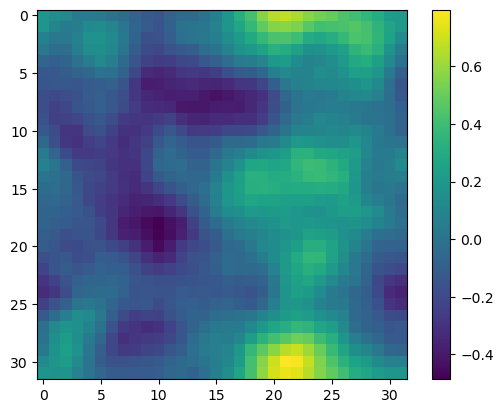

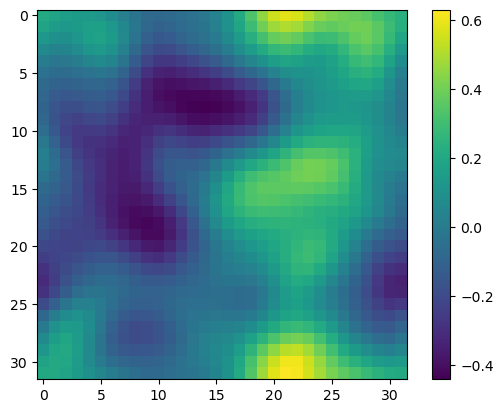

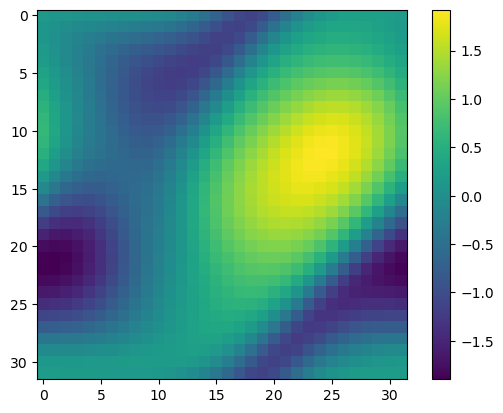

In [39]:
from matplotlib import pyplot as plt

id = 0

plt.figure()
plt.imshow(u0[id])
plt.colorbar()

plt.figure()
plt.imshow(u[id,0])
plt.colorbar()

plt.figure()
plt.imshow(u[id,-1])
plt.colorbar()

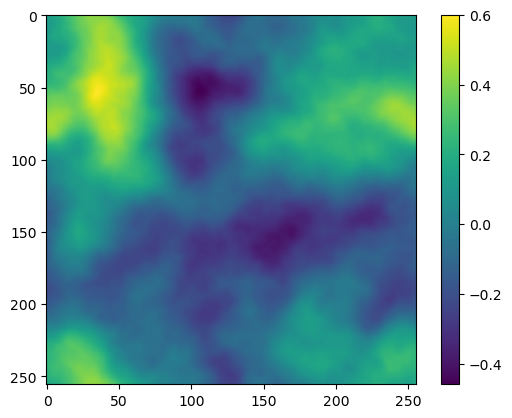

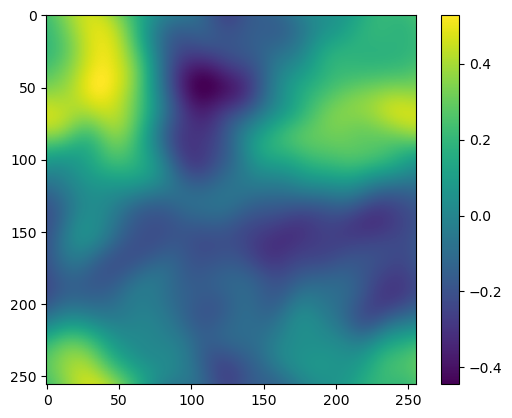

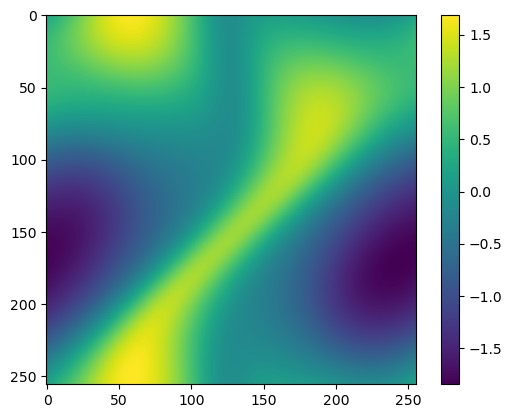

In [12]:
from matplotlib import pyplot as plt

id = 0

plt.figure()
plt.imshow(u0[id])
plt.colorbar()

plt.figure()
plt.imshow(u[id,0])
plt.colorbar()

plt.figure()
plt.imshow(u[id,-1])
plt.colorbar()

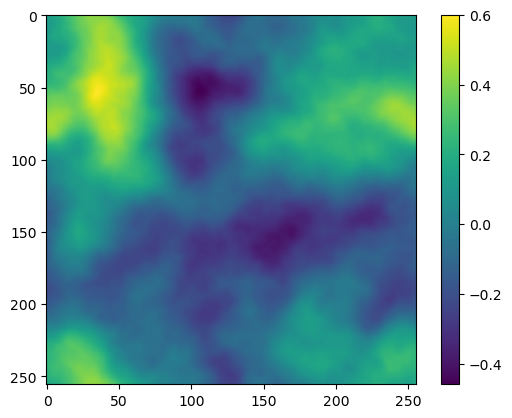

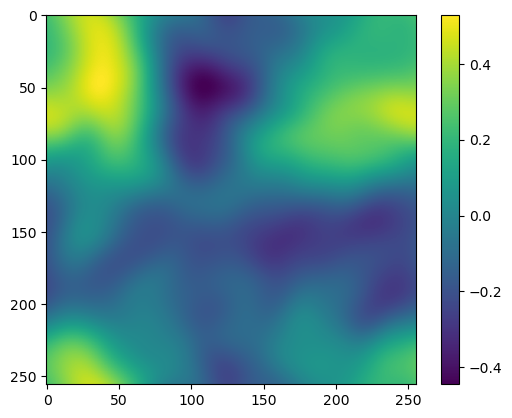

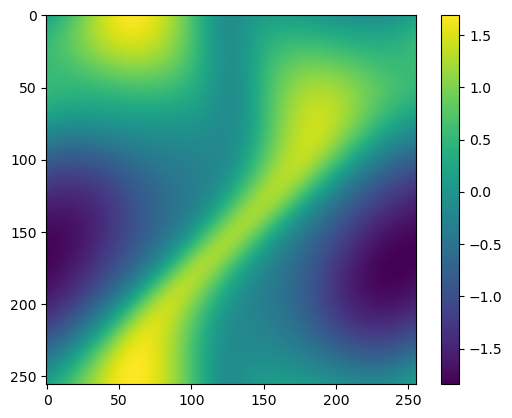

In [10]:
from matplotlib import pyplot as plt

id = 0

plt.figure()
plt.imshow(u0[id])
plt.colorbar()

plt.figure()
plt.imshow(u[id,0])
plt.colorbar()

plt.figure()
plt.imshow(u[id,-1])
plt.colorbar()